In [1]:

import os
import sys
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn import svm
from sklearn.pipeline import Pipeline
import os.path
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, permutation_test_score, StratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score,make_scorer
from copy import deepcopy
import argparse

from core_classification_functions import *
current_path = os.getcwd()
from mixed_sigmoid_normalisation import MixedSigmoidScaler
data_path="/Users/abry4213/data/fMRI_classification/"

%load_ext rpy2.ipython

In [34]:
%%R
# Load tidyverse R package
suppressPackageStartupMessages({
    library(cowplot)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())

    # Source my custom correctR code
    source("/Users/abry4213/github/correctR/R/repkfold_ttest.R")
})

## Load metadata

In [41]:
UCLA_CNP_metadata = pd.read_feather(f"{data_path}/input_data/UCLA_CNP_sample_metadata_filtered.feather")
ABIDE_metadata = pd.read_feather(f"{data_path}/input_data/ABIDE_sample_metadata_filtered.feather").assign(Study="ABIDE")

## Compute covariance for UCLA CNP

In [ ]:
def compute_covariance_for_subject(subject_TS):
    # Compute the covariance between all Brain_Region pairs
    cov_results = (subject_TS
                .pivot(index=["Sample_ID", "timepoint"], columns="Brain_Region", values="values")
                .cov()
                .melt(var_name="brain_region_from", value_name="values", ignore_index=False)
                .reset_index()
                .assign(Sample_ID = subject)
                .rename(columns={"Brain_Region":"brain_region_to"})
                .query("brain_region_from != brain_region_to")
                .assign(group_var = "Covariance"))

    # Take only the upper triangle of the covariance matrix
    cov_results_sorted = [sorted(pair) for pair in cov_results[["brain_region_from", "brain_region_to"]].values.tolist()]
    cov_results['region_pair'] = ['_'.join(string) for string in cov_results_sorted]
    cov_results = (cov_results
                .drop(["brain_region_from", "brain_region_to"], axis=1)
                .drop_duplicates(ignore_index=True, subset=['Sample_ID', 'region_pair'])
                )
    
    return cov_results


## Compute covariance for (1) UCLA CNP and (2) ABIDE

In [5]:
# UCLA CNP covariance
# Load filtered subject list
UCLA_CNP_filtered_subjects = pd.read_feather(f"{data_path}/time_series_features/UCLA_CNP_filtered_sample_info_catch25_pyspi14.feather")

if not os.path.exists(f"{data_path}/time_series_features/UCLA_CNP_covariance.feather"):
    # Load time-series for UCLA CNP
    UCLA_CNP_fMRI_TS = pd.read_feather(f"{data_path}/input_data/UCLA_CNP_fMRI_TS.feather").query("Sample_ID in @UCLA_CNP_filtered_subjects.Sample_ID")

    UCLA_CNP_covariance_results_list = []
    for subject in UCLA_CNP_fMRI_TS["Sample_ID"].unique():
        subject_TS = UCLA_CNP_fMRI_TS.query("Sample_ID == @subject")
        cov_results = compute_covariance_for_subject(subject_TS)
        UCLA_CNP_covariance_results_list.append(cov_results)

    # Concatenate all results
    UCLA_CNP_covariance_results = pd.concat(UCLA_CNP_covariance_results_list, ignore_index=True)
    # Save to a feather file
    UCLA_CNP_covariance_results.to_feather(f"{data_path}/time_series_features/UCLA_CNP_covariance.feather")
else:
    UCLA_CNP_covariance_results = pd.read_feather(f"{data_path}/time_series_features/UCLA_CNP_covariance.feather")

# ABIDE covariance
# Load filtered subject list
ABIDE_filtered_subjects = pd.read_feather(f"{data_path}/time_series_features/ABIDE_filtered_sample_info_catch25_pyspi14.feather")

if not os.path.exists(f"{data_path}/time_series_features/ABIDE_covariance.feather"):
    # Load time-series for ABIDE
    ABIDE_fMRI_TS = pd.read_feather(f"{data_path}/input_data/ABIDE_fMRI_TS.feather").query("Sample_ID in @ABIDE_filtered_subjects.Sample_ID")

    ABIDE_covariance_results_list = []
    for subject in ABIDE_fMRI_TS["Sample_ID"].unique():
        subject_TS = ABIDE_fMRI_TS.query("Sample_ID == @subject")
        cov_results = compute_covariance_for_subject(subject_TS)
        ABIDE_covariance_results_list.append(cov_results)

    # Concatenate all results
    ABIDE_covariance_results = pd.concat(ABIDE_covariance_results_list, ignore_index=True)
    # Save to a feather file
    ABIDE_covariance_results.to_feather(f"{data_path}/time_series_features/ABIDE_covariance.feather")
else:
    ABIDE_covariance_results = pd.read_feather(f"{data_path}/time_series_features/ABIDE_covariance.feather")

## Perform case--control classification using the covariance data for each disorder

In [18]:
def classify_based_on_covariance(dataset_ID, disorder, data_path, covariance_data, metadata, pipe, num_folds, num_repeats, CV_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names):
    if not os.path.isfile(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{dataset_ID}_{disorder}_{Analysis_Type}_{grouping_var}_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV_main_res.feather"):
        # Define main output data file for this feature
        main_output_file_base = f"{dataset_ID}_{disorder}_{Analysis_Type}_{grouping_var}_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV"

        IDs_to_keep = metadata.query("Diagnosis in [@disorder, 'Control']")["Sample_ID"].tolist()
        disorder_covariance_data = covariance_data.query("Sample_ID in @IDs_to_keep")

        # Pivot from long to wide
        disorder_covariance_data_wide = disorder_covariance_data.merge(metadata).pivot(index=['Sample_ID', 'Diagnosis'], columns='region_pair', values='values')

        # Extract sample ID and diagnosis
        index_data = disorder_covariance_data_wide.index.to_frame().reset_index(drop=True)
        class_labels = np.array([int(i==disorder) for i in index_data["Diagnosis"].tolist()])
        sample_IDs = np.array(index_data["Sample_ID"].tolist())

        # Impute any NaN with column mean
        disorder_covariance_data_imputed = disorder_covariance_data_wide.fillna(disorder_covariance_data_wide.mean())

        # Extract only the feature data
        disorder_covariance_only = disorder_covariance_data_imputed.reset_index(drop=True).to_numpy()

        # Run classification
        main_classification_res, splits_df, null_classification_res = run_k_fold_classifier_for_feature(feature_data = disorder_covariance_only, 
                                                                                        pipe = pipe,
                                                                                        CV_splitter = CV_splitter,
                                                                                        class_labels=class_labels,
                                                                                        sample_IDs = sample_IDs,
                                                                                        scorers=scorers,
                                                                                        scoring_names=scoring_names,
                                                                                        num_null_iters=num_null_iters,
                                                                                        num_folds = num_folds,
                                                                                        num_repeats = num_repeats,
                                                                                        num_jobs = num_jobs)
        
        # Add 1 to Fold and Repeat
        main_classification_res["Fold"] = main_classification_res["Fold"] + 1
        main_classification_res["Repeat"] = main_classification_res["Repeat"] + 1
        
        # Assign key details to dataframes
        main_classification_res["Disorder"] = disorder
        main_classification_res["Study"] = dataset_ID
        main_classification_res["Analysis_Type"] = Analysis_Type
        main_classification_res["group_var"] = grouping_var
        main_classification_res["Classifier_Type"] = classifier_type

        # Save results
        main_classification_res.to_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{main_output_file_base}_main_res.feather")
        

In [19]:
# Define classification parameters
model = svm.SVC(kernel="linear", C=1, class_weight="balanced")
pipe = Pipeline([('scaler', MixedSigmoidScaler(unit_variance=True)),
            ('model', model)])
num_folds=10
num_repeats=10
num_null_iters=0
num_jobs=1

# Analysis parameters
Analysis_Type="pyspi14_SPI"
grouping_var="covariance"
classifier_type="Linear_SVM_sklearn"

# Define scorers
scorers = [make_scorer(balanced_accuracy_score)]
scoring_names = ["Balanced_Accuracy"]

# Define RepeatedStratifiedKFold splitter
RepeatedStratifiedKFold_splitter = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=127)

# UCLA CNP classification
for disorder in ['SCZ', 'BP', 'ADHD']:
    dataset_ID = "UCLA_CNP"
    classify_based_on_covariance(dataset_ID, disorder, data_path, UCLA_CNP_covariance_results, UCLA_CNP_metadata, pipe, num_folds, num_repeats, RepeatedStratifiedKFold_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names)

# ABIDE classification
for disorder in ['ASD']:
    dataset_ID = "ABIDE"
    classify_based_on_covariance(dataset_ID, disorder, data_path, ABIDE_covariance_results, ABIDE_metadata, pipe, num_folds, num_repeats, RepeatedStratifiedKFold_splitter, num_null_iters, num_jobs, Analysis_Type, grouping_var, classifier_type, scorers, scoring_names)

# Merge the covariance results
if not os.path.exists(f"{data_path}/classification_results/pairwise_covariance_only_balanced_accuracy_results_all_folds.feather"):
    covariance_results_list = []
    for disorder in ['SCZ', 'BP', 'ADHD']:
        dataset_ID = "UCLA_CNP"
        covariance_results = pd.read_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{dataset_ID}_{disorder}_{Analysis_Type}_{grouping_var}_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV_main_res.feather")
        covariance_results_list.append(covariance_results)
    for disorder in ['ASD']:
        dataset_ID = "ABIDE"
        covariance_results = pd.read_feather(f"{data_path}/classification_results/balanced_accuracy/{dataset_ID}_{disorder}/{dataset_ID}_{disorder}_{Analysis_Type}_{grouping_var}_{classifier_type}_{num_repeats}_repeats_{num_folds}_folds_CV_main_res.feather")
        covariance_results_list.append(covariance_results)

    # Concatenate results
    all_covariance_results = pd.concat(covariance_results_list, ignore_index=True)
    # Save to a feather file
    all_covariance_results.to_feather(f"{data_path}/classification_results/pairwise_covariance_only_balanced_accuracy_results_all_folds.feather")
else:
    all_covariance_results = pd.read_feather(f"{data_path}/classification_results/pairwise_covariance_only_balanced_accuracy_results_all_folds.feather")

## Compare covariance results vs. Pearson correlation coefficient across disorders

In [20]:
# Classification results using Pearson correlation
pearson_correlation_balanced_accuracy_all_folds = pd.read_feather(f"{data_path}/classification_results/pairwise_balanced_accuracy_results_all_folds.feather").query("group_var == 'cov_EmpiricalCovariance'")

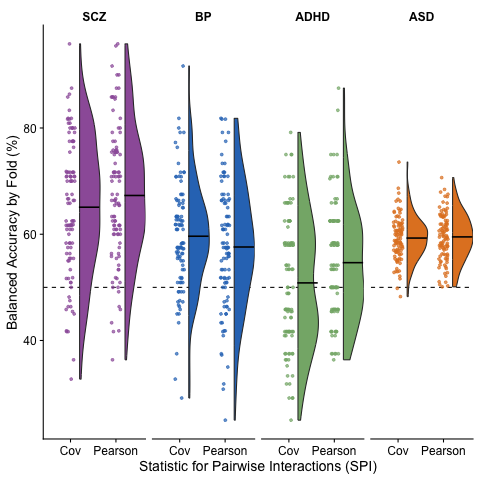

In [22]:
%%R -i pearson_correlation_balanced_accuracy_all_folds,all_covariance_results

plyr::rbind.fill(pearson_correlation_balanced_accuracy_all_folds, all_covariance_results) %>%
    mutate(SPI_label = ifelse(group_var=="covariance", "Cov", "Pearson"),
           Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
    ggplot(data=., mapping=aes(x=SPI_label, y=Balanced_Accuracy*100, fill=Disorder)) +
    geom_hline(yintercept=50, linetype="dashed", color="black") +
  geom_violinhalf(aes(fill=Disorder), scale="width", 
                  position = position_nudge(x=0.2))  +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.45, linewidth=0.3, 
       show.legend=FALSE, position = position_nudge(x=0.41)) +
  geom_point(aes(color = Disorder), position = position_jitter(width = 0.1),
             size = 1, alpha=0.7) +
    facet_grid(.~Disorder) +
    xlab("Statistic for Pairwise Interactions (SPI)") +
    ylab("Balanced Accuracy by Fold (%)") +
  scale_color_manual(values = c("SCZ" = "#9d60a8", 
                                "BP" = "#2F77C0", 
                                "ADHD" = "#84b278", 
                                "ASD" = "#E28328"),
                    na.value = "grey80") +
  scale_fill_manual(values = c("SCZ" = "#9d60a8", 
                               "BP" = "#2F77C0", 
                               "ADHD" = "#84b278", 
                               "ASD" = "#E28328"),
                    na.value = "grey80") +
    theme(legend.position="none", 
          strip.background = element_blank(),
          strip.text = element_text(face="bold")) 
# ggsave("../../plots/pairwise_results/Pearson_vs_Raw_Covariance_results.png", width=6, height=3.75, units="in", dpi=300)

### Statistically compare covariance vs. Pearson correlation coefficient with corrected resampled T-statistic test

In [44]:
%%R -i pearson_correlation_balanced_accuracy_all_folds,all_covariance_results,UCLA_CNP_metadata,ABIDE_metadata -o corrected_SPI_T_res,results_df

# Compile a study lookup table
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE"),
                              Disorder = c("SCZ", "BP", "ADHD", "ASD"))

run_correctR_group <- function(disorder, study, metadata, results_df) {
  # Find number of subjects for the specified comparison group
  num_subjects <- metadata %>%
    filter(Study == study, 
           Diagnosis %in% c("Control", disorder)) %>%
    distinct(Sample_ID) %>%
    nrow()
  
  # Compute the training and test fold sizes for 10-fold CV
  training_size <- ceiling(0.9*num_subjects)
  test_size <- floor(0.1*num_subjects)
  
  # Prep the resulting balanced accuracies with vs without univariate data
  data_for_correctR <- results_df %>%
    filter(Study == study, 
           Disorder == disorder) %>%
    dplyr::rename("model" = "group_var",
                  "k" = "Fold",
                  "r" = "Repeat",
                  "values" = "Balanced_Accuracy") %>%
    dplyr::select(model, k, r, values) %>%
    dplyr::mutate(r = r + 1)

    res <- as.data.frame(repkfold_ttest(data = data_for_correctR, 
                                        n1 = training_size,
                                        n2 = test_size,
                                        k = 10,
                                        r = 10, 
                                        tailed = "two")) %>%
      ungroup() %>%
      mutate(p_value_corr_BenjaminiHochberg = p.adjust(p.value, method="BH"),
             Disorder = disorder)

    return(res)
}

results_df = plyr::rbind.fill(pearson_correlation_balanced_accuracy_all_folds,all_covariance_results)
combined_metadata = plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_metadata)

corrected_SPI_T_res <- 1:nrow(study_group_df) %>%
  purrr::map_df(~ run_correctR_group(disorder = study_group_df$Disorder[.x],
                                     study = study_group_df$Study[.x],
                                     metadata = combined_metadata,
                                     results_df = results_df))

In [45]:
# Print the corrected resampled T-statistic results
corrected_SPI_T_res

,statistic,p.value,p_value_corr_BenjaminiHochberg,Disorder
1,0.598079,0.551153,0.551153,SCZ
2,-0.576069,0.565876,0.565876,BP
3,1.097408,0.275125,0.275125,ADHD
4,0.290171,0.772292,0.772292,ASD
